# Assessment of the SST climatology and variability

## Import packages

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import tqdm
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")

## Define Parameters

In [2]:
# Time
# Note: Time period from December year_start-1 to November year_stop
year_start = 1982
year_stop = 2011

## Define Parameters

In [3]:
# Requests
request_dicts = {
    "ESACCI": {
        "collection_id": "satellite-sea-surface-temperature",
        "request": {
            "processinglevel": "level_4",
            "format": "zip",
            "variable": "all",
            "sensor_on_satellite": "combined_product",
            "version": "2_1",
        },
        "chunks": {"year": 1, "month": 1},
    },
    "GMPE": {
        "collection_id": "satellite-sea-surface-temperature-ensemble-product",
        "request": {
            "format": "zip",
            "variable": "all",
        },
        "chunks": {"year": 1, "month": 1, "day": 12},  # CDS limit is 12
    },
}

# Parameters to speed up I/O
open_mfdataset_kwargs = {
    "concat_dim": "time",
    "combine": "nested",
    "data_vars": "minimal",
    "coords": "minimal",
    "compat": "override",
    "parallel": True,
}

## Functions to cache

In [4]:
def get_masked_sst(ds):
    da = ds["analysed_sst"]
    if "mask" in ds:
        da = da.where(ds["mask"] == 1)
    with xr.set_options(keep_attrs=True):
        da -= 273.15
    da.attrs["units"] = "°C"
    return da


def add_chunksizes(da):
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da


def rechunk(obj):
    """Use NetCDF chunks."""
    chunks = {"time": 1, "year": 1, "season": 1, "latitude": 1_200, "longitude": 2_400}
    obj = obj.chunk(
        **{dim: chunksize for dim, chunksize in chunks.items() if dim in obj.dims}
    )
    if isinstance(obj, xr.DataArray):
        return add_chunksizes(obj)
    for da in obj.data_vars.values():
        add_chunksizes(da)
    return obj


def compute_time_reductions(ds, func, **kwargs):
    ds = rechunk(ds)
    da = get_masked_sst(ds)
    da_reduced = rechunk(func(da, **kwargs))
    if "season" in da_reduced.dims:
        da_reduced = da_reduced.sel(season=sorted(set(da["time"].dt.season.values)))
    return rechunk(da_reduced).to_dataset()

## Download and transform

In [5]:
# Settings
reductions = ("mean", "std")
season_month_dict = {
    "DJF": {"12", "01", "02"},
    "MAM": {"03", "04", "05"},
    "JJA": {"06", "07", "08"},
    "SON": {"09", "10", "11"},
}
start = f"{year_start-1}-12"
stop = f"{year_stop}-11"

# Initialize variables
datasets_annual = {}
datasets_seasonal = {}
for product, request_dict in request_dicts.items():
    kwargs = {
        "collection_id": request_dict["collection_id"],
        "transform_chunks": False,
        "chunks": request_dict["chunks"],
        **open_mfdataset_kwargs,
    }

    # Annual
    print(f"{product=}")
    annual_ds_list = []
    for year in tqdm.tqdm(range(year_start, year_stop + 1), desc="annual"):
        # Note: year from December year-1 to November year
        annual_requests = download.update_request_date(
            request_dict["request"],
            start=f"{year-1}-12",
            stop=f"{year}-11",
            stringify_dates=True,
        )
        tmp_ds_list = []
        for reduction in reductions:
            func = getattr(diagnostics, f"time_weighted_{reduction}")
            ds = download.download_and_transform(
                **kwargs,
                requests=annual_requests,
                transform_func=compute_time_reductions,
                transform_func_kwargs={"func": func, "weights": False},
            )
            tmp_ds_list.append(rechunk(ds).expand_dims(reduction=[reduction]))
        annual_ds_list.append(
            xr.concat(tmp_ds_list, "reduction").expand_dims(year=[year])
        )
    datasets_annual[product] = xr.concat(annual_ds_list, "year")

    # Seasonal
    requests = download.update_request_date(
        request_dict["request"],
        start=start,
        stop=stop,
        stringify_dates=True,
    )
    seasonal_ds_list = []
    for season, months in tqdm.tqdm(season_month_dict.items(), desc="season"):
        season_requests = [
            {
                k: v
                if k != "month"
                else sorted(set({v} if isinstance(v, str) else v) & months)
                for k, v in r.items()
            }
            for r in requests
        ]
        tmp_ds_list = []
        for reduction in reductions:
            # Seasonal
            func = getattr(diagnostics, f"seasonal_weighted_{reduction}")
            ds = download.download_and_transform(
                **kwargs,
                requests=season_requests,
                transform_func=compute_time_reductions,
                transform_func_kwargs={"func": func, "weights": False},
            )
            tmp_ds_list.append(rechunk(ds).expand_dims(reduction=[reduction]))
        seasonal_ds_list.append(xr.concat(tmp_ds_list, "reduction"))
    datasets_seasonal[product] = xr.concat(seasonal_ds_list, "season")

del tmp_ds_list, annual_ds_list, seasonal_ds_list

product='ESACCI'


season: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


product='GMPE'


season: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


## Define plotting functions

In [6]:
def coarsen_and_concat(datasets_dict):
    datasets = []
    for product, ds in datasets_dict.items():
        if product == "ESACCI":
            ds = ds.coarsen(latitude=5, longitude=5).mean()
            ds["latitude"] = ds["latitude"].round(3)
            ds["longitude"] = ds["longitude"].round(3)
        datasets.append(ds.expand_dims(product=[product]))
    return xr.concat(datasets, "product")


def plot_mean_and_std(ds, prefix, **kwargs):
    default_kwargs = {
        "projection": ccrs.Robinson(),
        "plot_func": "contourf",
        "center": False,
        "col": "product",
        "robust": True,
        "show_stats": False,
    }
    for reduction, da in ds["analysed_sst"].groupby("reduction"):
        (extra_dim, ) = (set(da.dims) - {"product", "latitude", "longitude"}) or {None}
        plot_kwargs = default_kwargs | kwargs
        plot_kwargs.setdefault(
            "cmap", "Spectral_r" if reduction == "mean" else "tab20b"
        )
        plot_kwargs.setdefault("row", extra_dim)
        title = f"{prefix}{reduction.title()} ({start}, {stop})"
        plot.projected_map(da, **plot_kwargs)
        plt.suptitle(title)
        plt.show()


def plot_mean_and_std_bias(ds, prefix, **kwargs):
    default_kwargs = {
        "projection": ccrs.Robinson(),
        "plot_func": "contourf",
        "center": 0,
        "col_wrap": 2,
        "robust": True,
        "show_stats": False,
    }
    for reduction, da in ds["analysed_sst"].groupby("reduction"):
        (extra_dim, ) = (set(da.dims) - {"product", "latitude", "longitude"}) or {None}
        plot_kwargs = default_kwargs | kwargs
        plot_kwargs.setdefault("cmap", "PRGn")
        plot_kwargs.setdefault("col", extra_dim)
        title = (
            f"{prefix} bias of {reduction.title()} ({start}, {stop})"
            + "\n"
            + " - ".join(da["product"][::-1].values)
        )
        with xr.set_options(keep_attrs=True):
            da = da.diff("product").squeeze()
        plot.projected_map(da, **plot_kwargs)
        plt.suptitle(title)
        plt.show()

## Plot annual data

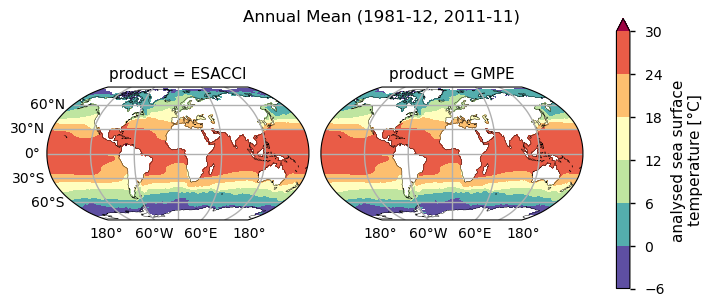

/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


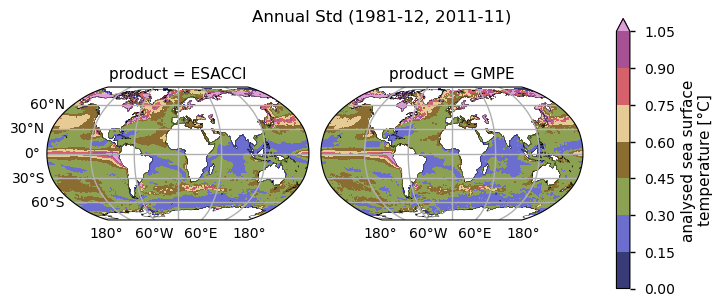

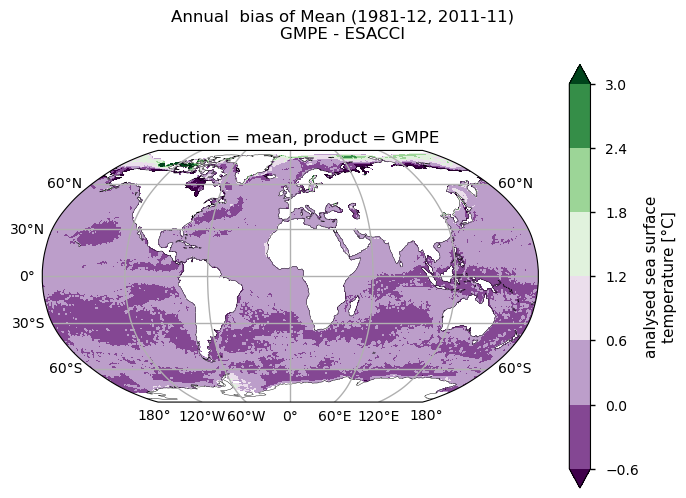

/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
ds_annual_low_res = coarsen_and_concat(datasets_annual).sel(reduction="mean")
datasets = []
for reduction in ("mean", "std"):
    ds = getattr(ds_annual_low_res, reduction)("year", keep_attrs=True)
    datasets.append(ds.expand_dims(reduction=[reduction]))
ds_annual_low_res = xr.concat(datasets, "reduction")
prefix = "Annual "
plot_mean_and_std(ds_annual_low_res, prefix)
plot_mean_and_std_bias(ds_annual_low_res, prefix)

## Plot seasonal data

In [ ]:
ds_seasonal_low_res = coarsen_and_concat(datasets_seasonal)
plot_mean_and_std(ds_seasonal_low_res)
prefix = "Seasonal "
plot_mean_and_std(ds_seasonal_low_res, prefix)
plot_mean_and_std_bias(ds_seasonal_low_res, prefix)